# Homework 11 Assignment 2: Cluster time trends in NYC businesses

In [100]:
%matplotlib inline
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pylab as plt
import os
import sys
import geopandas
from fiona.crs import from_epsg
import pysal as ps
import seaborn as sns
import json
import pylab as pl
import pandas as pd
import re
from scipy import cluster
import matplotlib.pyplot as plt
%matplotlib inline

#from PIL import Image
import zipfile
import sklearn.cluster
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

from IPython.display import Image
s = json.load( open(os.getenv('PUI2016')+'/fbb_matplotlibrc.json') )
pl.rcParams.update(s)

import os
import sys
print (os.getenv("PUIDATA"))


/home/cusp/fhl204/PUIdata


In [2]:
#Download census data for businesses by ZIP code
!for ((y=93; y<=99; y+=1)); do wget ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp$y\totals.zip; done
!for ((y=0; y<=1; y+=1)); do wget ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp0$y\totals.zip; done
!for ((y=2; y<=9; y+=1)); do wget ftp://ftp.census.gov/econ200$y\/CBP_CSV/zbp0$y\totals.zip; done
!for ((y=10; y<=15; y+=1)); do wget ftp://ftp.census.gov/econ20$y\/CBP_CSV/zbp$y\totals.zip; done

--2016-12-12 13:57:13--  ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp93totals.zip
           => “zbp93totals.zip”
Resolving ftp.census.gov... 148.129.75.35, 2610:20:2010:a09:1000:0:9481:4b23
Connecting to ftp.census.gov|148.129.75.35|:21... connected.
Logging in as anonymous ... 
Error in server response, closing control connection.
Retrying.

--2016-12-12 14:02:14--  ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp93totals.zip
  (try: 2) => “zbp93totals.zip”
Connecting to ftp.census.gov|148.129.75.35|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /Econ2001_And_Earlier/CBP_CSV ... done.
==> SIZE zbp93totals.zip ... done.
==> PASV ... done.    ==> RETR zbp93totals.zip ... 
No such file “zbp93totals.zip”.

--2016-12-12 14:02:15--  ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp94totals.zip
           => “zbp94totals.zip”
Resolving ftp.census.gov... 148.129.75.35, 2610:20:2010:a09:1000:

In [73]:
#Download NYC Zip Codes Shape File
#Source: http://data.nycprepared.org/dataset/nyc-zip-code-tabulation-areas/resource/0c0e14e9-78e1-404e-97b0-c2fabceb3981
#Copy of the geojson file saved to PUIData
filename = "nyc-zip-code-tabulation-areas-polygons.geojson"
#os.system("mv " + filename + " " + os.getenv("PUIDATA"))
NYCZipCodes = geopandas.read_file(os.getenv("PUIDATA") + "/" + filename)
NYCZipCodes

,@id,BLDGpostalCode,CTY_FIPS,OBJECTID,PO_NAME,STATE,ST_FIPS,Shape_Area,Shape_Leng,borough,geometry,postalCode
0,http://nyc.pediacities.com/Resource/PostalCode...,0,081,1,Jackson Heights,NY,36,2.016328e+07,20624.692317,Queens,POLYGON ((-73.86942457284175 40.74915687096787...,11372
1,http://nyc.pediacities.com/Resource/PostalCode...,0,081,2,Glen Oaks,NY,36,2.260653e+07,23002.816039,Queens,POLYGON ((-73.71068374074007 40.75004039450917...,11004
2,http://nyc.pediacities.com/Resource/PostalCode...,0,081,3,New Hyde Park,NY,36,6.269333e+06,15749.161511,Queens,POLYGON ((-73.70098278625547 40.73889569923034...,11040
3,http://nyc.pediacities.com/Resource/PostalCode...,0,081,4,Bellerose,NY,36,4.941836e+07,35932.810639,Queens,POLYGON ((-73.72270447144122 40.75373371438336...,11426
4,http://nyc.pediacities.com/Resource/PostalCode...,0,081,5,Fresh Meadows,NY,36,6.938587e+07,38693.565676,Queens,POLYGON ((-73.81088634744755 40.72717187575918...,11365
5,http://nyc.pediacities.com/Resource/PostalCode...,0,081,6,Elmhurst,NY,36,4.265940e+07,33755.870988,Queens,POLYGON ((-73.88722098467157 40.72752618766134...,11373
6,http://nyc.pediacities.com/Resource/PostalCode...,0,081,7,Floral Park,NY,36,9.155180e+06,13594.924549,Queens,POLYGON ((-73.70098278625547 40.73889569923034...,11001
7,http://nyc.pediacities.com/Resource/PostalCode...,0,081,8,Forest Hills,NY,36,5.558777e+07,36277.076839,Queens,"POLYGON ((-73.8562474640478 40.7367227854824, ...",11375
8,http://nyc.pediacities.com/Resource/PostalCode...,0,081,9,Queens Village,NY,36,3.956834e+07,31231.968593,Queens,POLYGON ((-73.74168681424477 40.73682340115314...,11427
9,http://nyc.pediacities.com/Resource/PostalCode...,0,081,10,Rego Park,NY,36,2.520346e+07,26323.994393,Queens,POLYGON ((-73.86451198956482 40.73407164841783...,11374


In [74]:
NYCZip = NYCZipCodes[['Shape_Area', 'Shape_Leng', 'borough', 'geometry', 'postalCode']]
NYCZip.rename(columns={'postalCode':'ZIP'}, inplace=True)
NYCZip['ZIP'] = NYCZip['ZIP'].astype(str)
NYCZip.head()

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,Shape_Area,Shape_Leng,borough,geometry,ZIP
0,2.016328e+07,20624.692317,Queens,POLYGON ((-73.86942457284175 40.74915687096787...,11372
1,2.260653e+07,23002.816039,Queens,POLYGON ((-73.71068374074007 40.75004039450917...,11004
2,6.269333e+06,15749.161511,Queens,POLYGON ((-73.70098278625547 40.73889569923034...,11040
3,4.941836e+07,35932.810639,Queens,POLYGON ((-73.72270447144122 40.75373371438336...,11426
4,6.938587e+07,38693.565676,Queens,POLYGON ((-73.81088634744755 40.72717187575918...,11365


In [ ]:
#Move all downloaded files to PUIData
os.system("mkdir -p " + os.getenv("PUIDATA") + "/CensusBusinessData")
os.system("mv " + "*.zip " + os.getenv("PUIDATA") + "/CensusBusinessData")

In [39]:
#Merge census data to one data frame; remove zips with no info
path = os.getenv("PUIDATA") + "/CensusBusinessData/"
mydata = []
year1 = ['94', '95', '96', '97']
for yr in year1:
    filename = 'zbp' + yr + 'totals.zip'
    zf = zipfile.ZipFile(path + filename)
    df = pd.read_csv(zf.open(filename.replace('.zip','.txt')),
        index_col = [0],
        usecols = ['zip','est'])
    df.rename(columns = {'est': yr}, inplace=True)
    mydata.append(df)

In [40]:
year2 = ['98', '99', '00', '01', '02']
for yr in year2:
    filename = 'zbp' + yr + 'totals.zip'
    zf = zipfile.ZipFile(path + filename)
    df = pd.read_csv(zf.open(filename.replace('.zip','.txt')),
        index_col = [0],
        usecols = ['ZIP','EST'])
    df.rename(columns = {'EST': yr}, inplace=True)
    mydata.append(df)

In [41]:
year3 = ['03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14']
for yr in year3:
    filename = 'zbp' + yr + 'totals.zip'
    zf = zipfile.ZipFile(path + filename)
    df = pd.read_csv(zf.open(filename.replace('.zip','.txt')),
        index_col = [0],
        usecols = ['zip','est'])
    df.rename(columns = {'est': yr}, inplace=True)
    mydata.append(df)

In [42]:
#merge datasets in proper format
bizData = mydata[0]
for i in np.arange(len(mydata) -1) + 1:
    bizData = pd.merge(bizData, mydata[i], left_index=True, right_index=True, how='inner')
bizData.head()

,94,95,96,97,98,99,00,01,02,03,...,05,06,07,08,09,10,11,12,13,14
1001,439,439,433,457,444,469,493,490,490,505,...,509,509,503,477,458,448,436,453,439,458
1002,450,467,487,500,490,558,563,587,566,586,...,589,582,596,584,571,570,558,572,572,560
1003,10,10,13,15,14,13,13,13,15,16,...,12,12,16,17,16,16,16,15,15,18
1004,47,48,47,41,31,35,48,37,23,21,...,31,30,20,18,18,21,19,16,16,13
1005,92,95,101,104,95,82,86,90,94,93,...,94,98,106,97,87,96,91,94,97,97


In [43]:
#setup variables for data normalization
df_sd = bizData.std(axis = 1)
df_mean = bizData.mean(axis = 1)

In [44]:
#Data Whitening: dividing each feature by its standard deviation. Whitenings decorrelates the data: 
#it makes the features independent so that the data covariance matrix is the identity matrix. 
#Here instead you want to standardize your time series: 
#subtract the mean and divide each time series (separately) by its standard deviation.
#zipbizdata[i].std() should be 1 for all i in range(len(Nzipcodes))
#zipbizdata[i].mean() should be ~0 for all i in range(len(Nzipcodes))

for cols in bizData.columns:
    bizData[cols] = (bizData[cols] - df_mean) / df_sd

In [45]:
#convert zip to string for merge
bizData['ZIP'] = bizData.index.astype(str)
bizData.shape

(35885, 22)

In [76]:
#merge census data with map to drop zips not needed
zipbizdata = pd.merge(bizData, NYCZip, how='inner', on=['ZIP'])
zipbizdata.head()

,94,95,96,97,98,99,00,01,02,03,...,10,11,12,13,14,ZIP,Shape_Area,Shape_Leng,borough,geometry
0,-1.839191,-1.193297,-1.287641,-0.714319,0.011404,-0.140998,0.468610,-0.467573,-0.808663,-1.222326,...,-0.082940,-0.184541,-0.126483,0.149292,0.845986,10001,1.779494e+07,19254.442129,Manhattan,POLYGON ((-74.00827017711134 40.75258714368449...
1,-1.713540,-1.626405,-1.377447,-1.053802,-1.168323,-0.964178,-0.486179,0.176049,-0.506095,-0.174982,...,0.995120,1.094703,1.199265,1.283911,1.244077,10002,2.628013e+07,36484.417965,Manhattan,POLYGON ((-73.97441674489379 40.73642441865476...
2,-1.820497,-1.434653,-1.307101,-0.930824,-0.567301,-0.535414,-0.458882,-0.717175,-0.672532,-0.391918,...,0.912298,1.058983,1.234367,1.435260,1.613833,10003,1.553838e+07,17396.136890,Manhattan,POLYGON ((-73.97986374196766 40.73497446573838...
3,-1.512649,-1.438217,-1.363786,-1.032980,-1.008170,-0.536772,-0.032293,-0.420990,-0.371369,-0.379639,...,0.827802,0.877423,1.191688,1.497684,2.117945,10004,4.001782e+06,13769.878563,Manhattan,"POLYGON ((-74.00596661578348 40.7043243225291,..."
4,-1.512649,-1.438217,-1.363786,-1.032980,-1.008170,-0.536772,-0.032293,-0.420990,-0.371369,-0.379639,...,0.827802,0.877423,1.191688,1.497684,2.117945,10004,1.202708e+06,6450.069454,Manhattan,POLYGON ((-74.04166368343016 40.69644987183209...


In [47]:
#drop string columns before clustering
zipbizdata.drop(['Shape_Area', 'Shape_Leng', 'borough', 'geometry', 'postalCode'], axis=1, inplace=True)
zipbizdata.shape

(243, 21)

In [49]:
#2. Cluster the NUMBER OF ESTABLISHMENTS time series with K-means
#http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

kmeans = KMeans(n_clusters=5, random_state=0).fit(zipbizdata)
klabels = kmeans.labels_

In [50]:
len(klabels)

243

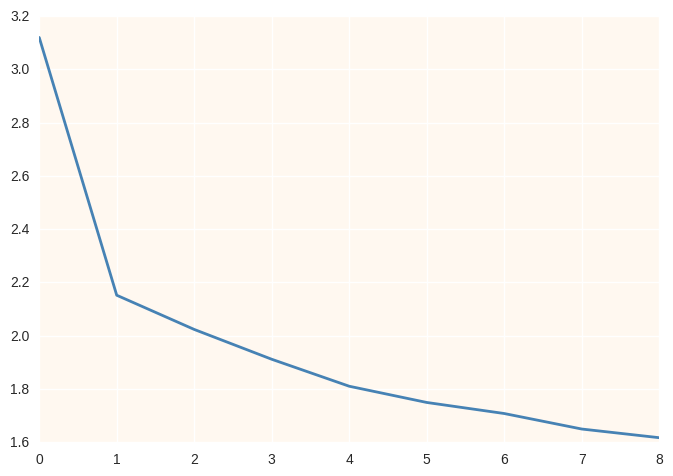

In [13]:
#3. Plot the cluster centers (if you used K means those are the means of the clusters). 
#Plot for example the cluster centers overlayed on each time series 
#(using the alpha channel to control the opacity in the plot may be helpful here).

#source: http://stats.stackexchange.com/questions/9850/how-to-plot-data-output-of-clustering
#Determine how many clusters

initial = [cluster.vq.kmeans(zipbizdata,i) for i in range(1,10)]
pyplot.plot([var for (cent,var) in initial])
pyplot.show()

In [16]:
cent, var = initial[2]
#use vq() to get as assignment for each obs.
assignment,cdist = cluster.vq.vq(zipbizdata,cent)
pyplot.scatter(zipbizdata[0], zipbizdata[0], c = assignment)
pyplot.show()

KeyError: 0

In [54]:
#4. Use another clustering algorithm
#http://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering
aggCluster = AgglomerativeClustering(n_clusters=6).fit(zipbizdata)
agglabels = aggCluster.labels_

In [77]:
#5. Overlay your data on a NYC map: you can use shapefiles for the zip codes and different colors for different clusters

zipbizdata = pd.merge(bizData, NYCZip, how='inner', on=['ZIP'])
zipbizdata.head()

,94,95,96,97,98,99,00,01,02,03,...,10,11,12,13,14,ZIP,Shape_Area,Shape_Leng,borough,geometry
0,-1.839191,-1.193297,-1.287641,-0.714319,0.011404,-0.140998,0.468610,-0.467573,-0.808663,-1.222326,...,-0.082940,-0.184541,-0.126483,0.149292,0.845986,10001,1.779494e+07,19254.442129,Manhattan,POLYGON ((-74.00827017711134 40.75258714368449...
1,-1.713540,-1.626405,-1.377447,-1.053802,-1.168323,-0.964178,-0.486179,0.176049,-0.506095,-0.174982,...,0.995120,1.094703,1.199265,1.283911,1.244077,10002,2.628013e+07,36484.417965,Manhattan,POLYGON ((-73.97441674489379 40.73642441865476...
2,-1.820497,-1.434653,-1.307101,-0.930824,-0.567301,-0.535414,-0.458882,-0.717175,-0.672532,-0.391918,...,0.912298,1.058983,1.234367,1.435260,1.613833,10003,1.553838e+07,17396.136890,Manhattan,POLYGON ((-73.97986374196766 40.73497446573838...
3,-1.512649,-1.438217,-1.363786,-1.032980,-1.008170,-0.536772,-0.032293,-0.420990,-0.371369,-0.379639,...,0.827802,0.877423,1.191688,1.497684,2.117945,10004,4.001782e+06,13769.878563,Manhattan,"POLYGON ((-74.00596661578348 40.7043243225291,..."
4,-1.512649,-1.438217,-1.363786,-1.032980,-1.008170,-0.536772,-0.032293,-0.420990,-0.371369,-0.379639,...,0.827802,0.877423,1.191688,1.497684,2.117945,10004,1.202708e+06,6450.069454,Manhattan,POLYGON ((-74.04166368343016 40.69644987183209...


In [126]:
#Convert labels to data frames
km_labels = pd.DataFrame(klabels, columns = ["kmeans"])
ag_labels = pd.DataFrame(agglabels, columns = ["agglomerative"])
clustersLabels = pd.merge(km_labels, ag_labels, left_index=True, right_index=True)
zipClusters = pd.merge(NYCZipCodes, clustersLabels, left_index=True, right_index=True)
zipClusters.head()

,@id,BLDGpostalCode,CTY_FIPS,OBJECTID,PO_NAME,STATE,ST_FIPS,Shape_Area,Shape_Leng,borough,geometry,postalCode,kmeans,agglomerative
0,http://nyc.pediacities.com/Resource/PostalCode...,0,081,1,Jackson Heights,NY,36,2.016328e+07,20624.692317,Queens,POLYGON ((-73.86942457284175 40.74915687096787...,11372,0,4
1,http://nyc.pediacities.com/Resource/PostalCode...,0,081,2,Glen Oaks,NY,36,2.260653e+07,23002.816039,Queens,POLYGON ((-73.71068374074007 40.75004039450917...,11004,2,1
2,http://nyc.pediacities.com/Resource/PostalCode...,0,081,3,New Hyde Park,NY,36,6.269333e+06,15749.161511,Queens,POLYGON ((-73.70098278625547 40.73889569923034...,11040,2,1
3,http://nyc.pediacities.com/Resource/PostalCode...,0,081,4,Bellerose,NY,36,4.941836e+07,35932.810639,Queens,POLYGON ((-73.72270447144122 40.75373371438336...,11426,2,1
4,http://nyc.pediacities.com/Resource/PostalCode...,0,081,5,Fresh Meadows,NY,36,6.938587e+07,38693.565676,Queens,POLYGON ((-73.81088634744755 40.72717187575918...,11365,2,1


In [128]:
#convert label columns to floats
zipClusters.kmeans = zipbizClusters.kmeans.astype(float)
zipClusters.agglomerative = zipbizClusters.agglomerative.astype(float)
zipClusters.head()

,@id,BLDGpostalCode,CTY_FIPS,OBJECTID,PO_NAME,STATE,ST_FIPS,Shape_Area,Shape_Leng,borough,geometry,postalCode,kmeans,agglomerative
0,http://nyc.pediacities.com/Resource/PostalCode...,0,081,1,Jackson Heights,NY,36,2.016328e+07,20624.692317,Queens,POLYGON ((-73.86942457284175 40.74915687096787...,11372,0.0,4.0
1,http://nyc.pediacities.com/Resource/PostalCode...,0,081,2,Glen Oaks,NY,36,2.260653e+07,23002.816039,Queens,POLYGON ((-73.71068374074007 40.75004039450917...,11004,2.0,1.0
2,http://nyc.pediacities.com/Resource/PostalCode...,0,081,3,New Hyde Park,NY,36,6.269333e+06,15749.161511,Queens,POLYGON ((-73.70098278625547 40.73889569923034...,11040,2.0,1.0
3,http://nyc.pediacities.com/Resource/PostalCode...,0,081,4,Bellerose,NY,36,4.941836e+07,35932.810639,Queens,POLYGON ((-73.72270447144122 40.75373371438336...,11426,2.0,1.0
4,http://nyc.pediacities.com/Resource/PostalCode...,0,081,5,Fresh Meadows,NY,36,6.938587e+07,38693.565676,Queens,POLYGON ((-73.81088634744755 40.72717187575918...,11365,2.0,1.0


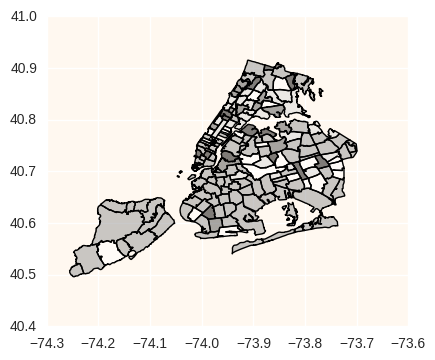

In [130]:
#zipbizClusters.plot
plt.figure(figsize=(20,20))
zipClusters.plot(column = 'kmeans')
#fig = plt.zipbizClusters()


In [107]:
plot?

Object `plot` not found.


In [ ]:
#6. Compare the results of the 2 algorithms

In [ ]:
#7. Interpretation

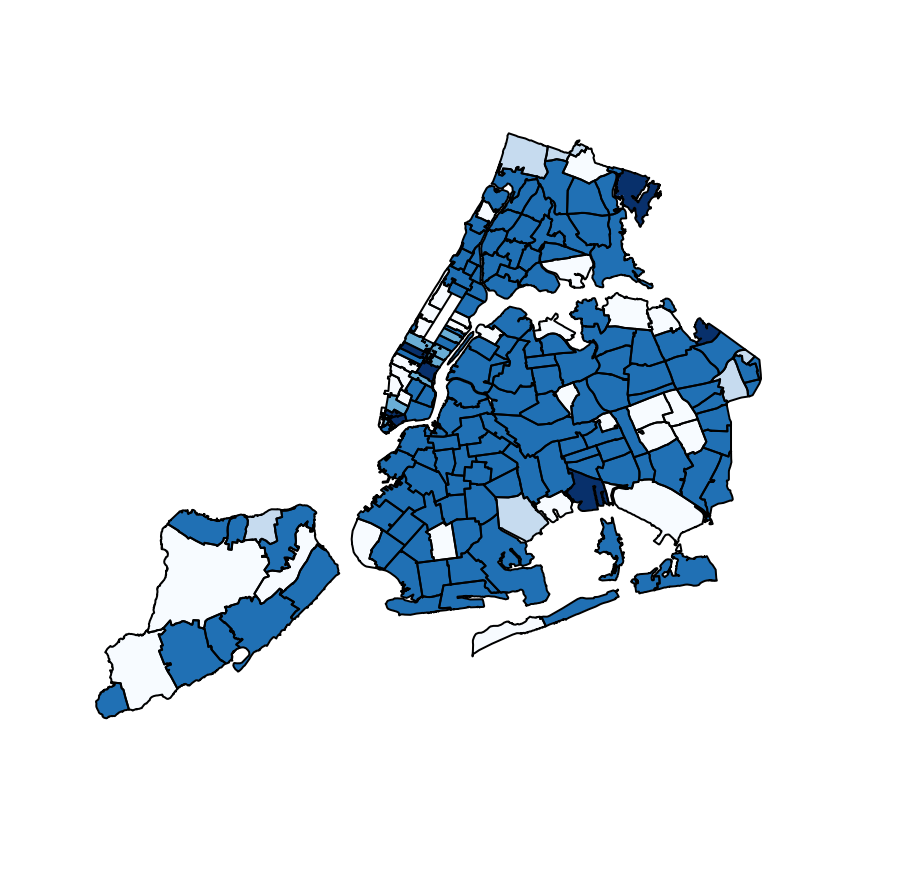

In [3]:
from PIL import Image
Image.open("clustermap.png")

And if you use hierarchical clustering and make a dandrogram it may look like this`

In [3]:
from PIL import Image
Image.open("dandrogram.png")

ImportError: No module named PIL

In [118]:
zipbizClusters2 = zipbizClusters.drop(['94', '95', '96', '97', '98', '99', '00', \
                                       '01', '02', '03', '04', '05', '06', '07', \
                                       '08', '09', '10', '11', '12', '13', '14'], axis=1, inplace=True)
zipbizClusters2.head()

AttributeError: 'NoneType' object has no attribute 'head'